# **Ingress란?**

* 네트워크 트래픽은 Ingress와 egress (잘 사용하지는 않는 단어이긴 하지만) 으로 구분.
* Ingress는 외부로부터 서버 내부로 유입되는 네트워크 트래픽
* egress는 서버 내부에서 외부로 나가는 트래픽


* HTTP(S) 기반의 L7 로드밸런싱 기능을 제공하는 컴포넌트이다.
* 외부에서 쿠버네티스 클러스터 내부로 들어오는 네트워크 요청(= Ingress 트래픽)을 어떻게 처리할지 정의한다. 
* Ingress는 외부에서 Kubernetes에서 실행 중인 Deployment와 Service에 접근하기 위한, 일종의 관문(Gateway) 같은 역할을 담당한다.
* Ingress를 사용하지 않았다고 가정했을 때, 외부 요청을 처리할 수 있는 선택지는 NodePort, ExternalIP 등이 있음.
* 일반적으로 Layer 4 (TCP, UDP) 에서의 요청을 처리하며, 네트워크 요청에 대한 세부적인 처리 로직을 구현 한계 존재.

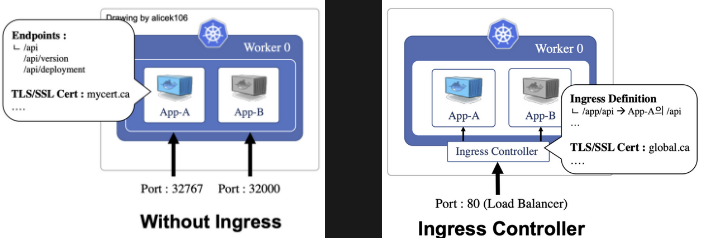

* 외부로부터 들어오는 요청에 대한 로드 밸런싱, TLS/SSL 인증서 처리, 특정 HTTP 경로의 라우팅 등을 Ingress를 통한 구체적 정의가능.

*  세부적인 로직을 모든 애플리케이션 개발 레벨에서 각각 구현하게 되면 서비스 운영 측면에서 추가적인 복잡성이 발생. 외부 요청을 어떻게 처리할 것인지를 정의하는 집합인 Ingress를 정의한 뒤, Ingress Controller 웹 서버에 적용함으로써 추상화된 단계에서 서비스 처리 로직을 정의.

* Ingress Controller 종류 및 사용 중인 클라우드 공급자에 따라 다양한 기능을 부가적으로 사용할 수도 있음, 서비스를 외부로 노출시켜 제공해야 한다면 Ingress를 사용하는 것이 바람직.

* Ingress 요청을 처리하기 위한 Service는 클라우드 플랫폼에서 제공되는 Load Balancer 타입의 Service를 사용.

* Private Cloud에서 운영하고 있는 서버에 Ingress를 직접 구축하게 된다면,  Service의 Type으로서 NodePort, ExternalIP, MetalLB 등을 대신 사용.

# **Ingress와 Ingress Controller**

쿠버네티스에서 Ingress를 사용하기 위해서는 두 가지가 필요.

1. YAML 파일에서 [**kind: Ingress**] 로 정의되는 Ingress 오브젝트
2. Ingress 규칙이 적용될 Ingress Controller. 


```
apiVersion: extensions/v1beta1
kind: Ingress
metadata:
 name: nginx-ingress
 annotations:
  nginx.ingress.kubernetes.io/rewrite-gartget:/
spec:
 rules:
 - host: alicek106.com
   http:
    paths:
    - path: /api/hostname-service
      backend:
       serviceName: hostname-service
       servicePort: 80

```



# **Ingress와 Ingress Controller**

1. alicek106.com 이라는 호스트 명으로 접근하는 네트워크 요청에 대해서 Ingress 규칙을 적용 
2. http 프로토콜을 통해 /api/hostname-service 라는 경로 접접근하는 요청 hostname-service 라는 이름의 Service의 80 포트로 전달 
([hostname-service](https://github.com/alicek106/aws-kubernetes-LB-example/blob/master/on-premise-ingress/2-internal-service.yaml)와 [hostname-deplyment](https://github.com/alicek106/aws-kubernetes-LB-example/blob/master/on-premise-ingress/1-echo-hostname.yaml)는 미리 생성되어 있다고 가정. 컨테이너의 호스트 이름을 확인하는 매우 간단한 예제)

* YAML 파일로부터 Ingress를 생성해도 아무 일도 일어나지 않음.
* Ingress는 단지 Ingress 규칙을 정의하는 선언적인 오브젝트일 뿐, 외부 요청을 받아들이는 실제 서버가 아님님. 
* Ingress는 **Ingress Controller**라고 하는 특수한 서버 컨테이너에 적용되어야만 Ingress에 적용된 규칙이 활성화.
* Ingress Controller가 외부로부터 네트워크 요청을 수신했을 때, Ingress 규칙에 기반해 이 요청을 어떻게 처리할지를 결정.

### Ingress Controller 설치하기

```yaml
kubectl apply -f https://raw.githubusercontent.com/kubernetes/ingress-nginx/controller-v1.3.0/deploy/static/provider/cloud/deploy.yaml
```

### Ingress 생성하기

* ingress에 사용될 deployment와 nodeport 생성
* GKE의 healthcheck를 해주기 위해 pod에 readinessProbe를 추가.
```yaml
# hello.deployment.yaml
apiVersion: apps/v1
kind: Deployment
metadata:
  name: go-gin
spec:
  replicas: 3
  selector:
    matchLabels:
      app: go-gin
  template:
    metadata:
      labels:
        app: go-gin
    spec:
      containers:
        - name: go-gin
          image: tae2089/gin:1.0.1
          ports:
            - containerPort: 8080
          readinessProbe:
            httpGet:
              path: ping
              port: 8080
          resources:
            limits:
              memory: "50Mi"
              cpu: "100m"
---
# hello.service.nodeport.yaml
apiVersion: v1
kind: Service
metadata:
  name: go-gin-nodeport
  labels:
    run: go-gin-nodeport
spec:
  type: NodePort # 서비스 타입
  ports:
    - port: 80 # 서비스 포트
      targetPort: 8080 # 타켓, 즉 pod의 포트
      protocol: TCP
      name: http
  selector:
    app: go-gin
```


**URL 기반으로 ingress 생성하기**

* hello.ingress.url.yaml이라는 명으로 파일을 생성해주고 다음과 같이 작성.

```yaml
apiVersion: networking.k8s.io/v1
kind: Ingress
metadata:
  name: go-gin-ingress
  annotations:
    kubernetes.io/ingress.class: "gce"
    kubernetes.io/ingress.global-static-ip-name: "ingress-webapps"
spec:
  rules:
    - http:
        paths:
          - path: /*
            pathType: ImplementationSpecific
            backend:
              service:
                name: go-gin-nodeport
                port:
                  number: 80
```

**host 기반의 ingress 생성하기**

* hello.ingress.host.yaml이라는 명으로 파일을 생성해주고 다음과 같이 작성.[host가 없으면 에러발생]

```yaml
apiVersion: networking.k8s.io/v1
kind: Ingress
metadata:
  name: go-gin-ingress
  annotations:
    kubernetes.io/ingress.class: "gce"
    kubernetes.io/ingress.global-static-ip-name: "ingress-webapps"
spec:
  rules:
    - host: dev.rokit.com
      http:
        paths:
          - path: /*
            pathType: ImplementationSpecific
            backend:
              service:
                name: go-gin-nodeport
                port:
                  number: 80
```
